Import Libraries

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

Load .env and Setup database connection

In [9]:
#Load environment variables
load_dotenv()

# Get credentials from environment variables
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASS')

# Create a database connection
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

#SQL Query
query = """
SELECT
    c."CustomerID",
    SUM(s."total_amount") AS total_sales,
    COUNT(s."InvoiceNo") AS order_frequency
FROM
    Dim_Customer c
JOIN
    Fact_Sales s ON c."CustomerID" = s."CustomerID"
GROUP BY
    c."CustomerID"
"""


Execute the query and check if the database is successfully connected.

In [10]:
#execute the query into the database
try:
    df = pd.read_sql(query, engine)
    # print the first few rows of the data
    print(df.head())
except Exception as e:
    print(f"An error occurred: {e}")
    print(f"Database connection: {engine}")  #to check the connection
    df = pd.DataFrame()  # Create an empty DataFrame in case of error

   CustomerID  total_sales  order_frequency
0       16592       3958.0              232
1       13527       2117.0              223
2       14173        260.0               25
3       12502       1684.0              100
4       14067        291.0               50


Preprocess the data (Normalize features)

In [11]:
#Preprocess the data: Normalize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['total_sales', 'order_frequency']])

Apply K-Means Clustering
    - an unsupervised learning algorithm used for data clustering, which groups unlabeled data points into groups or clusters.

In [13]:
#Apply K-Means clustering
k_means = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = k_means.fit_predict(df_scaled)

#Check the cluster centers to understand their meaning
cluster_center = k_means.cluster_centers_
print("Cluster Centers (total_sales, order_frequency):")
print(cluster_center)

Cluster Centers (total_sales, order_frequency):
[[-0.1657238  -0.14563587]
 [18.76872844 24.51628135]
 [ 1.89351076  1.55808357]]


Assign meaningful labels to clusters

In [14]:
# Assign meaning to the clusters based on the cluster centers
# Here, we assume:
# Cluster 0: High-Value Customers (higher total_sales and order_frequency)
# Cluster 1: Low-Value Customers (lower total_sales and order_frequency)
# Cluster 2: Moderate-Value Customers (moderate total_sales and order_frequency)

# Check the cluster centers and assign meaningful labels
if cluster_center[0][0] > cluster_center[1][0]:  # You can adjust the logic as needed
    cluster_labels = {
        0: 'High-Value Customers',
        1: 'Low-Value Customers',
        2: 'Moderate-Value Customers'
    }
else:
    cluster_labels = {
        0: 'Low-Value Customers',
        1: 'High-Value Customers',
        2: 'Moderate-Value Customers'
    }

# Add the cluster label to the customer data for better interpretation
df['Cluster Label'] = df['Cluster'].map(cluster_labels)

# Display the updated dataframe with cluster labels
df.head()

,CustomerID,total_sales,order_frequency,Cluster,Cluster Label
0,16592,3958.0,232,2,Moderate-Value Customers
1,13527,2117.0,223,0,Low-Value Customers
2,14173,260.0,25,0,Low-Value Customers
3,12502,1684.0,100,0,Low-Value Customers
4,14067,291.0,50,0,Low-Value Customers


Visualize the result from clustering

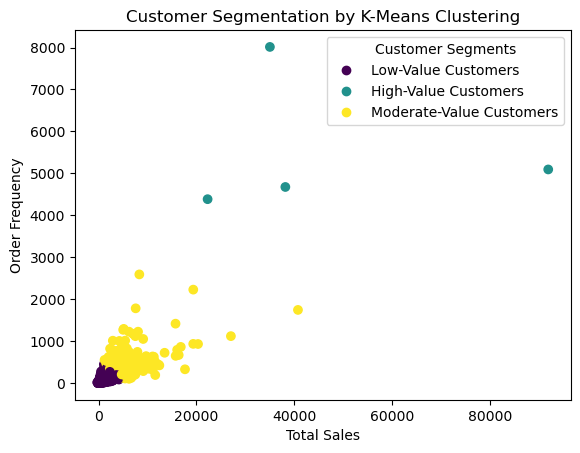

In [15]:
# Visualize the clustering result with color labels
scatter = plt.scatter(df['total_sales'], df['order_frequency'], 
                      c=df['Cluster'], cmap='viridis')

# Create a custom legend to show which color corresponds to which cluster
handles, _ = scatter.legend_elements()
legend_labels = [cluster_labels[i] for i in range(3)]
plt.legend(handles, legend_labels, title="Customer Segments")

# Label the axes and title
plt.xlabel('Total Sales')
plt.ylabel('Order Frequency')
plt.title('Customer Segmentation by K-Means Clustering')
plt.show()

Save the models and scaler

In [16]:
# Save the K-Means model and scaler
joblib.dump(k_means, 'customer_segmentation_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Evaluate clustering performance using three metrics:
> Sillhouette Score - measures how well-separated the clusters are, with higher-values indicating better clustering.
> Davies-Bouldin Index - assesses the average similarity between clusters, where lower values indicate better separation.
> Calinsk-Harabasz Index - evaluates the ratio of between-cluster to within-cluster dispersion, with higher values indicating well-defined clusters.

In [17]:
print("Evaluating clustering performance...")

silhouette_avg = silhouette_score(df_scaled, df['Cluster'])
print(f'\nSilhouette Score: {silhouette_avg:.4f}')

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(df_scaled, df['Cluster'])
print(f'Davies-Bouldin Index: {davies_bouldin:.4f}')

# Calculate Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(df_scaled, df['Cluster'])
print(f'Calinski-Harabasz Index: {calinski_harabasz:.4f}')

Evaluating clustering performance...

Silhouette Score: 0.7871
Davies-Bouldin Index: 0.5986
Calinski-Harabasz Index: 4693.8777
